In [ ]:
!pip install mapie scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.6/178.6 kB 2.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
#from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import mnist
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score, classification_mean_width_score
import matplotlib.pyplot as plt

In [ ]:
# Split into train, validation, and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Flatten images and normalize
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test  = x_test.reshape(x_test.shape[0], -1) / 255.0

# Further split training set into train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### MLP

In [ ]:
# Train MLPClassifier
# Is this redundant given the next MAPIE cell?
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=20, random_state=42)
mlp.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=20, random_state=42)

### Other models

In [ ]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize and add channel dimension for ResNet
x_train = x_train[..., None] / 255.0  # Shape: (num_samples, height, width, channels)
x_test = x_test[..., None] / 255.0    # Shape: (num_samples, height, width, channels)

# Further split training set into train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)


In [ ]:
# Load pretrained ResNet model from timm
import timm
import torch
resnet = timm.create_model('resnet18', pretrained=True, num_classes=10)
resnet.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjust for single-channel input
resnet.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [ ]:
def extract_features(data, model):
    data = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to PyTorch tensor and permute
    with torch.no_grad():
        features = model.forward_features(data).numpy()  # Extract features
    return features

x_train = extract_features(x_train, resnet)
x_val = extract_features(x_val, resnet)
x_test = extract_features(x_test, resnet)

Renaming model to `mlp` for compatibility with the rest of the code

In [ ]:
mlp = resnet

### MAPIE SPC

In [ ]:
# Apply MapieClassifier for Split Conformal Procedure
mapie = MapieClassifier(estimator=mlp, method="score", cv="split")
mapie.fit(x_val, y_val)

ValueError: Invalid estimator. Please provide a classifier with fit,predict, and predict_proba methods.

In [ ]:
# Predict with confidence intervals
alpha = 0.1
prediction, prediction_sets = mapie.predict(x_test, alpha=alpha)

In [ ]:
prediction_sets[0].flatten() # More comprehensive format?

array([False, False, False, False, False, False, False,  True, False,
       False])

In [ ]:
# Evaluate "empirical coverage" and set size
coverage = classification_coverage_score(y_test, prediction_sets.squeeze(axis=-1))
mean_set_size = classification_mean_width_score(prediction_sets.squeeze(axis=-1))

print(f"Coverage: {coverage:.2f}")
print(f"Mean prediction set size: {mean_set_size:.2f}")

Coverage: 0.91
Mean prediction set size: 0.92


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
#prediction, prediction_sets = mapie.predict(X_calib_noisy, alpha=0.1)\
prediction

array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
prediction_sets[0:2]

array([[[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False]],

       [[False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]]])

## No recalibration for each iteration, just Split CP

In [ ]:
prediction_sets.squeeze(axis=-1)[0]

array([False, False, False, False, False, False, False,  True, False,
       False])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

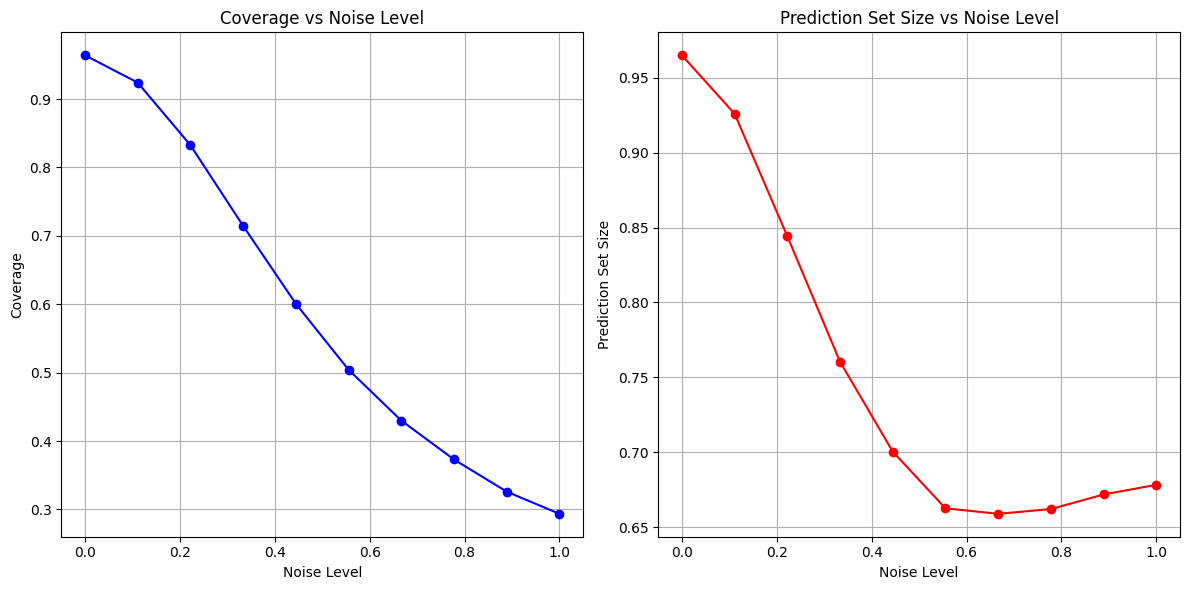

In [ ]:
def add_gaussian_noise(X, mean=0, std=0.1):
    return X + np.random.normal(loc=mean, scale=std, size=X.shape)

# Noise levels to test
noise_levels = np.linspace(0, 1, 10)

# Initialize lists to store the results
coverages = []
set_sizes = []


for noise_level in noise_levels:

    # Add Gaussian noise to the calibration set
    X_calib_noisy = add_gaussian_noise(x_val, mean=0, std=noise_level)

    # Predict using the fixed model on the noisy test set
    prediction, prediction_sets = mapie.predict(X_calib_noisy, alpha=0.1)

    # Calculate coverage for noisy calibration set
    coverage = classification_coverage_score(y_val, prediction_sets.squeeze(axis=-1))
    coverages.append(coverage)

    # Calculate the set size for noisy calibration set
    mean_set_size = classification_mean_width_score(prediction_sets.squeeze(axis=-1))
    set_sizes.append(mean_set_size)


plt.figure(figsize=(12, 6))

# Coverage vs Noise Level
plt.subplot(1, 2, 1)
plt.plot(noise_levels, coverages, marker='o', color='b')
plt.title('Coverage vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Coverage')
plt.grid(True)

# Set Size vs Noise Level
plt.subplot(1, 2, 2)
plt.plot(noise_levels, set_sizes, marker='o', color='r')
plt.title('Prediction Set Size vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Prediction Set Size')
plt.grid(True)

plt.tight_layout()
plt.show()

## With recalibration for each iteration, APS like

In [ ]:
from mapie.conformity_scores import APSConformityScore

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

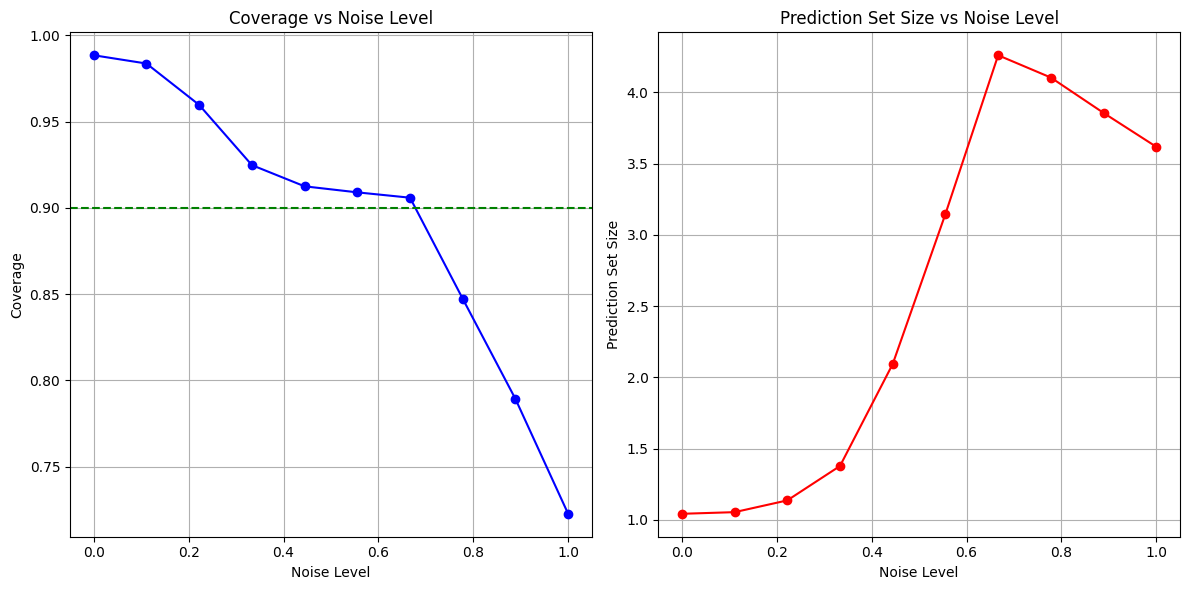

In [ ]:
alphas = np.arange(0.1, 1, 1)

method_params = {
    #"score": ("score", True),
    "aps":   ("aps", True)  # APS method
}

# Function to add Gaussian noise to the calibration set (X)
def add_gaussian_noise(X, mean=0, std=0.1):
    return X + np.random.normal(loc=mean, scale=std, size=X.shape) #imagenet c, dataset w standard distortions

# To store results
nulls, coverages, sizes = {}, {}, {}

# Define noise levels to test
noise_levels = np.linspace(0, 1, 10)  # Noise level from 0 to 1, in 10 steps

# Initialize MAPIE once with the pre-trained model and specific method (e.g., APS)
#mapie = MapieClassifier(estimator=mlp, method="aps", cv="prefit", random_state=42)
#mapie.fit(x_val, y_val)  # Fit MAPIE only once on the calibration set (no model refitting)

#cv="prefit", assumes that estimator has been fitted already.
#All data provided in the fit method is then used to calibrate the predictions through the score computation.
#At prediction time, quantiles of these scores are used to estimate prediction sets.


# Loop through different methods
for name, (method, include_last_label) in method_params.items():

    # Store results for each noise level
    coverages[name] = []
    sizes[name] = []
    nulls[name] = []

    # For each noise level, apply Gaussian noise to the calibration set to create a "test set"
    for noise_level in noise_levels:

        X_calib_noisy = add_gaussian_noise(x_val,  mean=0, std=noise_level) # Add Gaussian noise to the calibration set (using it as X_test)
        X_test_noisy  = add_gaussian_noise(x_test, mean=0, std=noise_level)

        # Initialize MAPIE with the specific method (e.g., APS) #was in prefit
        mapie = MapieClassifier(estimator=mlp, method=method, cv="prefit", random_state=42)#MapieClassifier(estimator=mlp, method=method, random_state=42) #was in split before MapieClassifier(estimator=mlp, method=method, cv="split", random_state=42)
        mapie.fit(X_calib_noisy, y_val)  # Fit MAPIE on the calibration set (no model refitting)

        # Predict using MAPIE for the noisy test set
        prediction, prediction_sets = mapie.predict(X_test_noisy, alpha=alphas, include_last_label=include_last_label) #X_test

        # Calculate empirical coverage for this noise level
        empirical_coverage = [classification_coverage_score(y_test, prediction_sets.squeeze(axis=-1)) for i, _ in enumerate(alphas)]
        coverages[name].append(empirical_coverage)

        # Calculate mean set size for this noise level
        mean_set_size = [prediction_sets.squeeze(axis=-1).sum(axis=1).mean() for i, _ in enumerate(alphas)]
        sizes[name].append(mean_set_size)


plt.figure(figsize=(12, 6))

# Coverage vs Noise Level
plt.subplot(1, 2, 1)
plt.plot(noise_levels, coverages['aps'], marker='o', color='b')
plt.axhline(y=1-alphas[0], color='g', linestyle='--', label=f'Alpha = {1-alphas[0]}')
plt.title('Coverage vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Coverage')
plt.grid(True)

# Set Size vs Noise Level
plt.subplot(1, 2, 2)
plt.plot(noise_levels, sizes['aps'], marker='o', color='r')
plt.title('Prediction Set Size vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Prediction Set Size')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
%%script false --no-raise-error

plt.figure(figsize=(12, 6))

# Coverage vs Noise Level
plt.subplot(1, 2, 1)
plt.plot(noise_levels, coverages['raps'], marker='o', color='b')
plt.axhline(y=1-alphas[0], color='g', linestyle='--', label=f'Alpha = {1-alphas[0]}')
plt.title('Coverage vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Coverage')
plt.grid(True)

# Set Size vs Noise Level
plt.subplot(1, 2, 2)
plt.plot(noise_levels, sizes['raps'], marker='o', color='r')
plt.title('Prediction Set Size vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Prediction Set Size')
plt.grid(True)

plt.tight_layout()
plt.show()

"naive", sum of the probabilities until the 1-alpha threshold.

"lac" (formerly called "score"), Least Ambiguous set-valued Classifier. It is based on the scores (i.e. 1 minus the softmax score of the true label) on the calibration set. See [1] for more details.

"aps" (formerly called “cumulated_score”), Adaptive Prediction Sets method. It is based on the sum of the softmax outputs of the labels until the true label is reached, on the calibration set. See [2] for more details.

https://mapie.readthedocs.io/en/stable/generated/mapie.classification.MapieClassifier.html
